In [27]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from IPython import display
from d2l import torch as d2l


batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4;

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    #此处加入一个resize是因为有时候我们可能需要尺寸更大的图片,而不仅仅是28*28的
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../datasets/", train=True, transform=trans, download=False)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../datasets/", train=False, transform=trans, download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))


train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [28]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

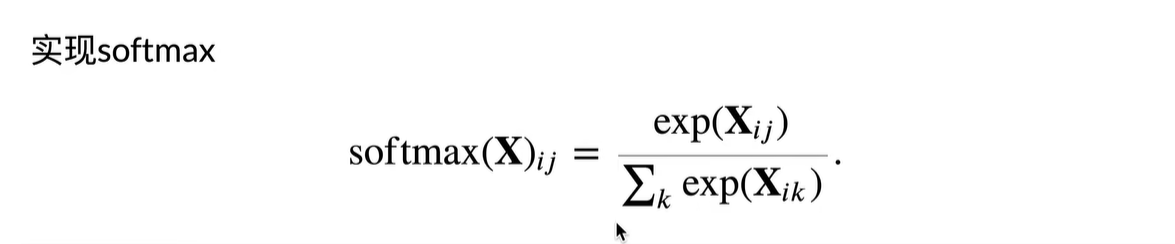

In [29]:
def softmax(X):
    #对X中的每一个元素做exp
    X_exp = torch.exp(X)
    #按照每一行进行求和,得到该行的
    partition = X_exp.sum(1, keepdim=True) 
    #
    return X_exp / partition

###### # softmax的验证

In [30]:
X = torch.normal(0, 1, (2, 5))
print(X)
X_prob = softmax(X)
X_prob, X_prob.sum(1)

tensor([[-0.9878,  0.3681,  0.6552,  2.9843, -0.5221],
        [-0.1462, -0.0209, -2.4231, -0.2473,  1.8445]])


(tensor([[0.0154, 0.0599, 0.0799, 0.8201, 0.0246],
         [0.0956, 0.1084, 0.0098, 0.0864, 0.6998]]),
 tensor([1.0000, 1.0000]))

###### 实现softmax回归模型

In [39]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

###### 创建一个数据y_hat,其中包含2个样本在3个类别的预测概率,使用y作为y_hat中的高铝的索引

In [42]:
# 整段代码的意思就是:
# y_hat是 2*3的矩阵,每行代表的是每次预测的三个不同样本的预测值,列代表的是不同类别的预测值
# 所以,y代表的就是预测值的下标,也可以认为是类别的下标
# y_hat[[0,1], y]代表的就是去找每次预测对应的类别
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat.shape

torch.Size([2, 3])

### 实现交叉熵函数
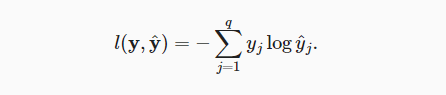

In [43]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)
# 得到的答案tensor([2.3026, 0.6931]) 就是样本0的预测损失和样本1的预测损失

tensor([2.3026, 0.6931])

In [44]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)#取每一行的最大值的下标
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

#### 评估在任意模型net的准确率

In [45]:
def evaluate_accuracy(net, data_iter):
    # 判断我们使用的是不是torch.hh的模型
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

- Accumulator实例中创建了2个变量,用于分别存储正确预测的数量和预测的总数量

In [46]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]
    
evaluate_accuracy(net, test_iter)

0.1308

### Softmax回归的训练

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if 